In [ ]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import numpy as np
import pycatch22 as catch22
import pickle
from sympy import real_roots
import statistics
import scipy.stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import fsolve

: 

In [2]:
def gen_limitCycle(num_samples): # num samples
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Limit Cycle Instances...')
    for i in range(num_samples):
        if i%100 == 0:
            print(f'{i}/{num_samples}')
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = 'HopfLC'
    return ts_hopf, df

In [4]:
ts_hopflc, df_hopflc = gen_limitCycle(2000)

Generating Limit Cycle Instances...
0/2000
100/2000
200/2000
300/2000
400/2000
500/2000
600/2000
700/2000
800/2000
900/2000
1000/2000
1100/2000
1200/2000
1300/2000
1400/2000
1500/2000
1600/2000
1700/2000
1800/2000
1900/2000


In [1547]:
def gen_fixedpoint(num_samples):
    
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-1.1, -0.98, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances (1/3)...')
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'HookesFP'

    # system 2 - hopf 
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, -0.01, size=num_samples) # sample 
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances (2/3)...')
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'HopfFP'

    # system 3 - bistable
    eta_val_bistable = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_bistable = np.concatenate([np.random.uniform(-5, -0.385, size=int(num_samples/2)), np.random.uniform(0.385, 5, size=int(num_samples/2))])
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances (3/3)...')
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = 'BistableFP'

    ts_fixedpt = np.vstack([ts_hookes, ts_hopf, ts_bistable])
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable])


    return ts_fixedpt, df_fixedpt

In [7]:
ts_fixedpt, df_fixedpt = gen_fixedpoint(1000)

Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...


In [8]:
def gen_switching(num_samples): # num samples 
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Loading Filter...')
    loaded_model = pickle.load(open('svm_model.sav', 'rb'))
    loaded_scaler = pickle.load(open('scaler_switching.sav', 'rb'))
    print('Generating Bistable Switching Instances...')
    for i in range(num_samples):
        # run loop until switching instance is generated
        while True:
            mu = np.random.uniform(-0.384, 0.384)
            eta = np.random.uniform(0.2, 1)
            def f(state, t):
                x = state
                dxdt = mu + x - x**3
                return dxdt
            ic = np.array([np.random.uniform()])
            gw = lambda y, t: eta * np.identity(ic.shape[0])
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            features = np.array(catch22.catch22_all(sol[500:])['values']).reshape(1,-1)
            if loaded_model.predict(loaded_scaler.transform(features)) == 1:
                break
        eta_val_bistable.append(eta)
        mu_val_bistable.append(mu)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'BistableSW'
    return ts_bistable, df

In [10]:
ts_switching, df_switching = gen_switching(2000)

Loading Filter...
Generating Bistable Switching Instances...


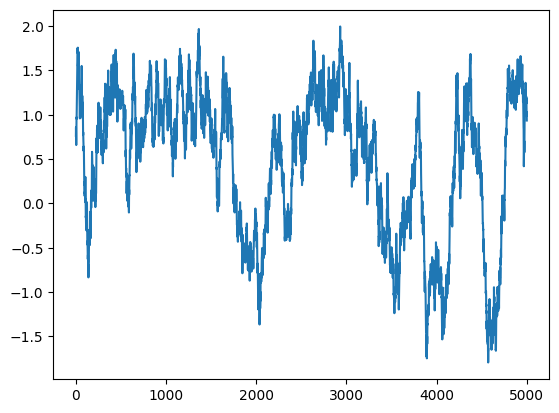

In [11]:
plt.plot(ts_switching[50])

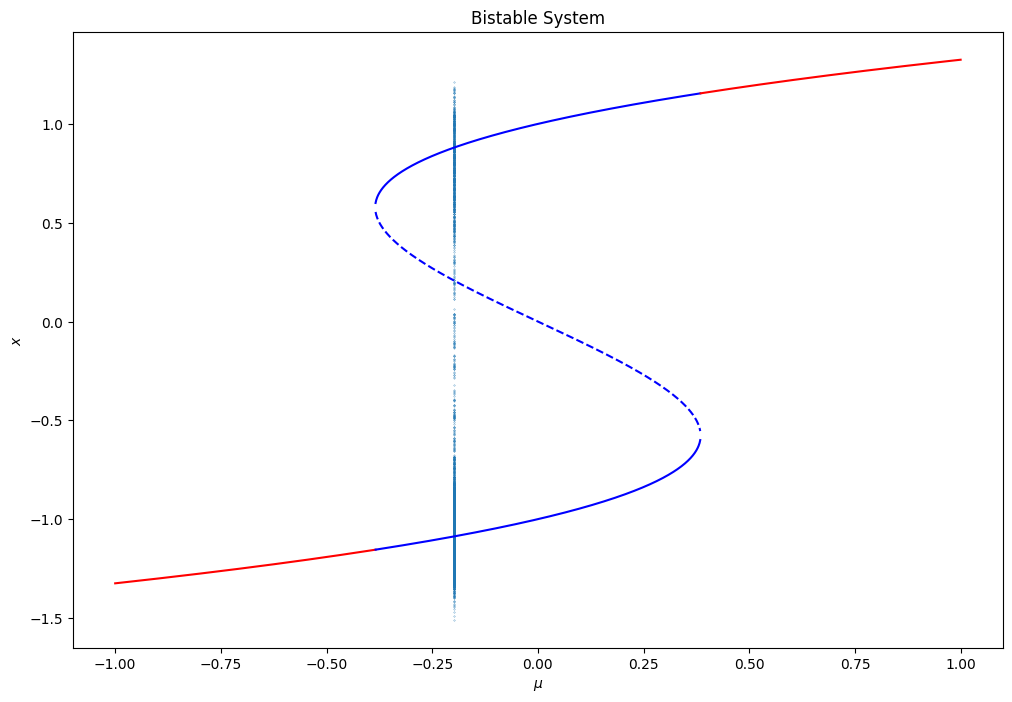

In [12]:
from scipy.optimize import fsolve

def bistable_func(x, *mu):
    return mu + x - x**3

mus1 = np.linspace(-1, -0.384, 1000)
res1 = [fsolve(bistable_func, args=mu, x0=[-1]) for mu in mus1] 
mus2 = np.linspace(-0.384, 0.384, 1000)
res2 = [fsolve(bistable_func, args=mu, x0=[-1, 0, 1]) for mu in mus2] 
# split into 3 columns for stable and unstable solutions
ary = np.array(res2)
bistable_stable1 = ary[:,0]
bistable_unstable = ary[:,1]
bistable_stable2 = ary[:,2]
mus3 = np.linspace(0.385, 1, 1000)
res3 = [fsolve(bistable_func, args=mu, x0=[1]) for mu in mus3] 
plt.figure(figsize=(12,8))
plt.plot(mus1, res1, color='r')
plt.plot(mus2, bistable_stable1, color='b', label='Bistable')
plt.plot(mus2, bistable_unstable, color='b', ls='--')
plt.plot(mus2, bistable_stable2, color='b')
plt.plot(mus3, res3, color='r', label='Fixed Point')
plt.scatter(np.ones((5000,1))*df_switching.iloc[20]['mu'], ts_switching[20], s=0.05)
plt.title('Bistable System')
plt.xlabel('$\mu$')
plt.ylabel('$x$')
plt.savefig('bistable_wo_vline.svg')

Dim Reduction

In [13]:
def MixedSigmoid(x, doScale=True):
    # use scaled sigmoid if iqr = 0, robust sigmoid otherwise
    medianX = np.median(x)
    iqrX = scipy.stats.iqr(x)

    # if iqr is zero, do standard sigmoid transformation
    if iqrX == 0:
        meanX = np.mean(x)
        stdX = np.std(x)
        xhat = 1/(1+np.exp(-(x-meanX)/stdX))
        if doScale:
            xhat = MinMaxScaler(feature_range=(0,1)).fit_transform(xhat)
    
    # apply robust sigmoid
    else:
        xhat = 1/(1 + np.exp(-(x-medianX)/(iqrX)))
        if doScale:
            xhat = MinMaxScaler(feature_range=(0,1)).fit_transform(xhat)
    return xhat

In [307]:
# create function to do splits of instances in specified ratio 
all_instances = np.vstack([df_fixedpt.iloc[:,:22], df_hopflc.iloc[:,:22], df_switching.iloc[:,:22]])

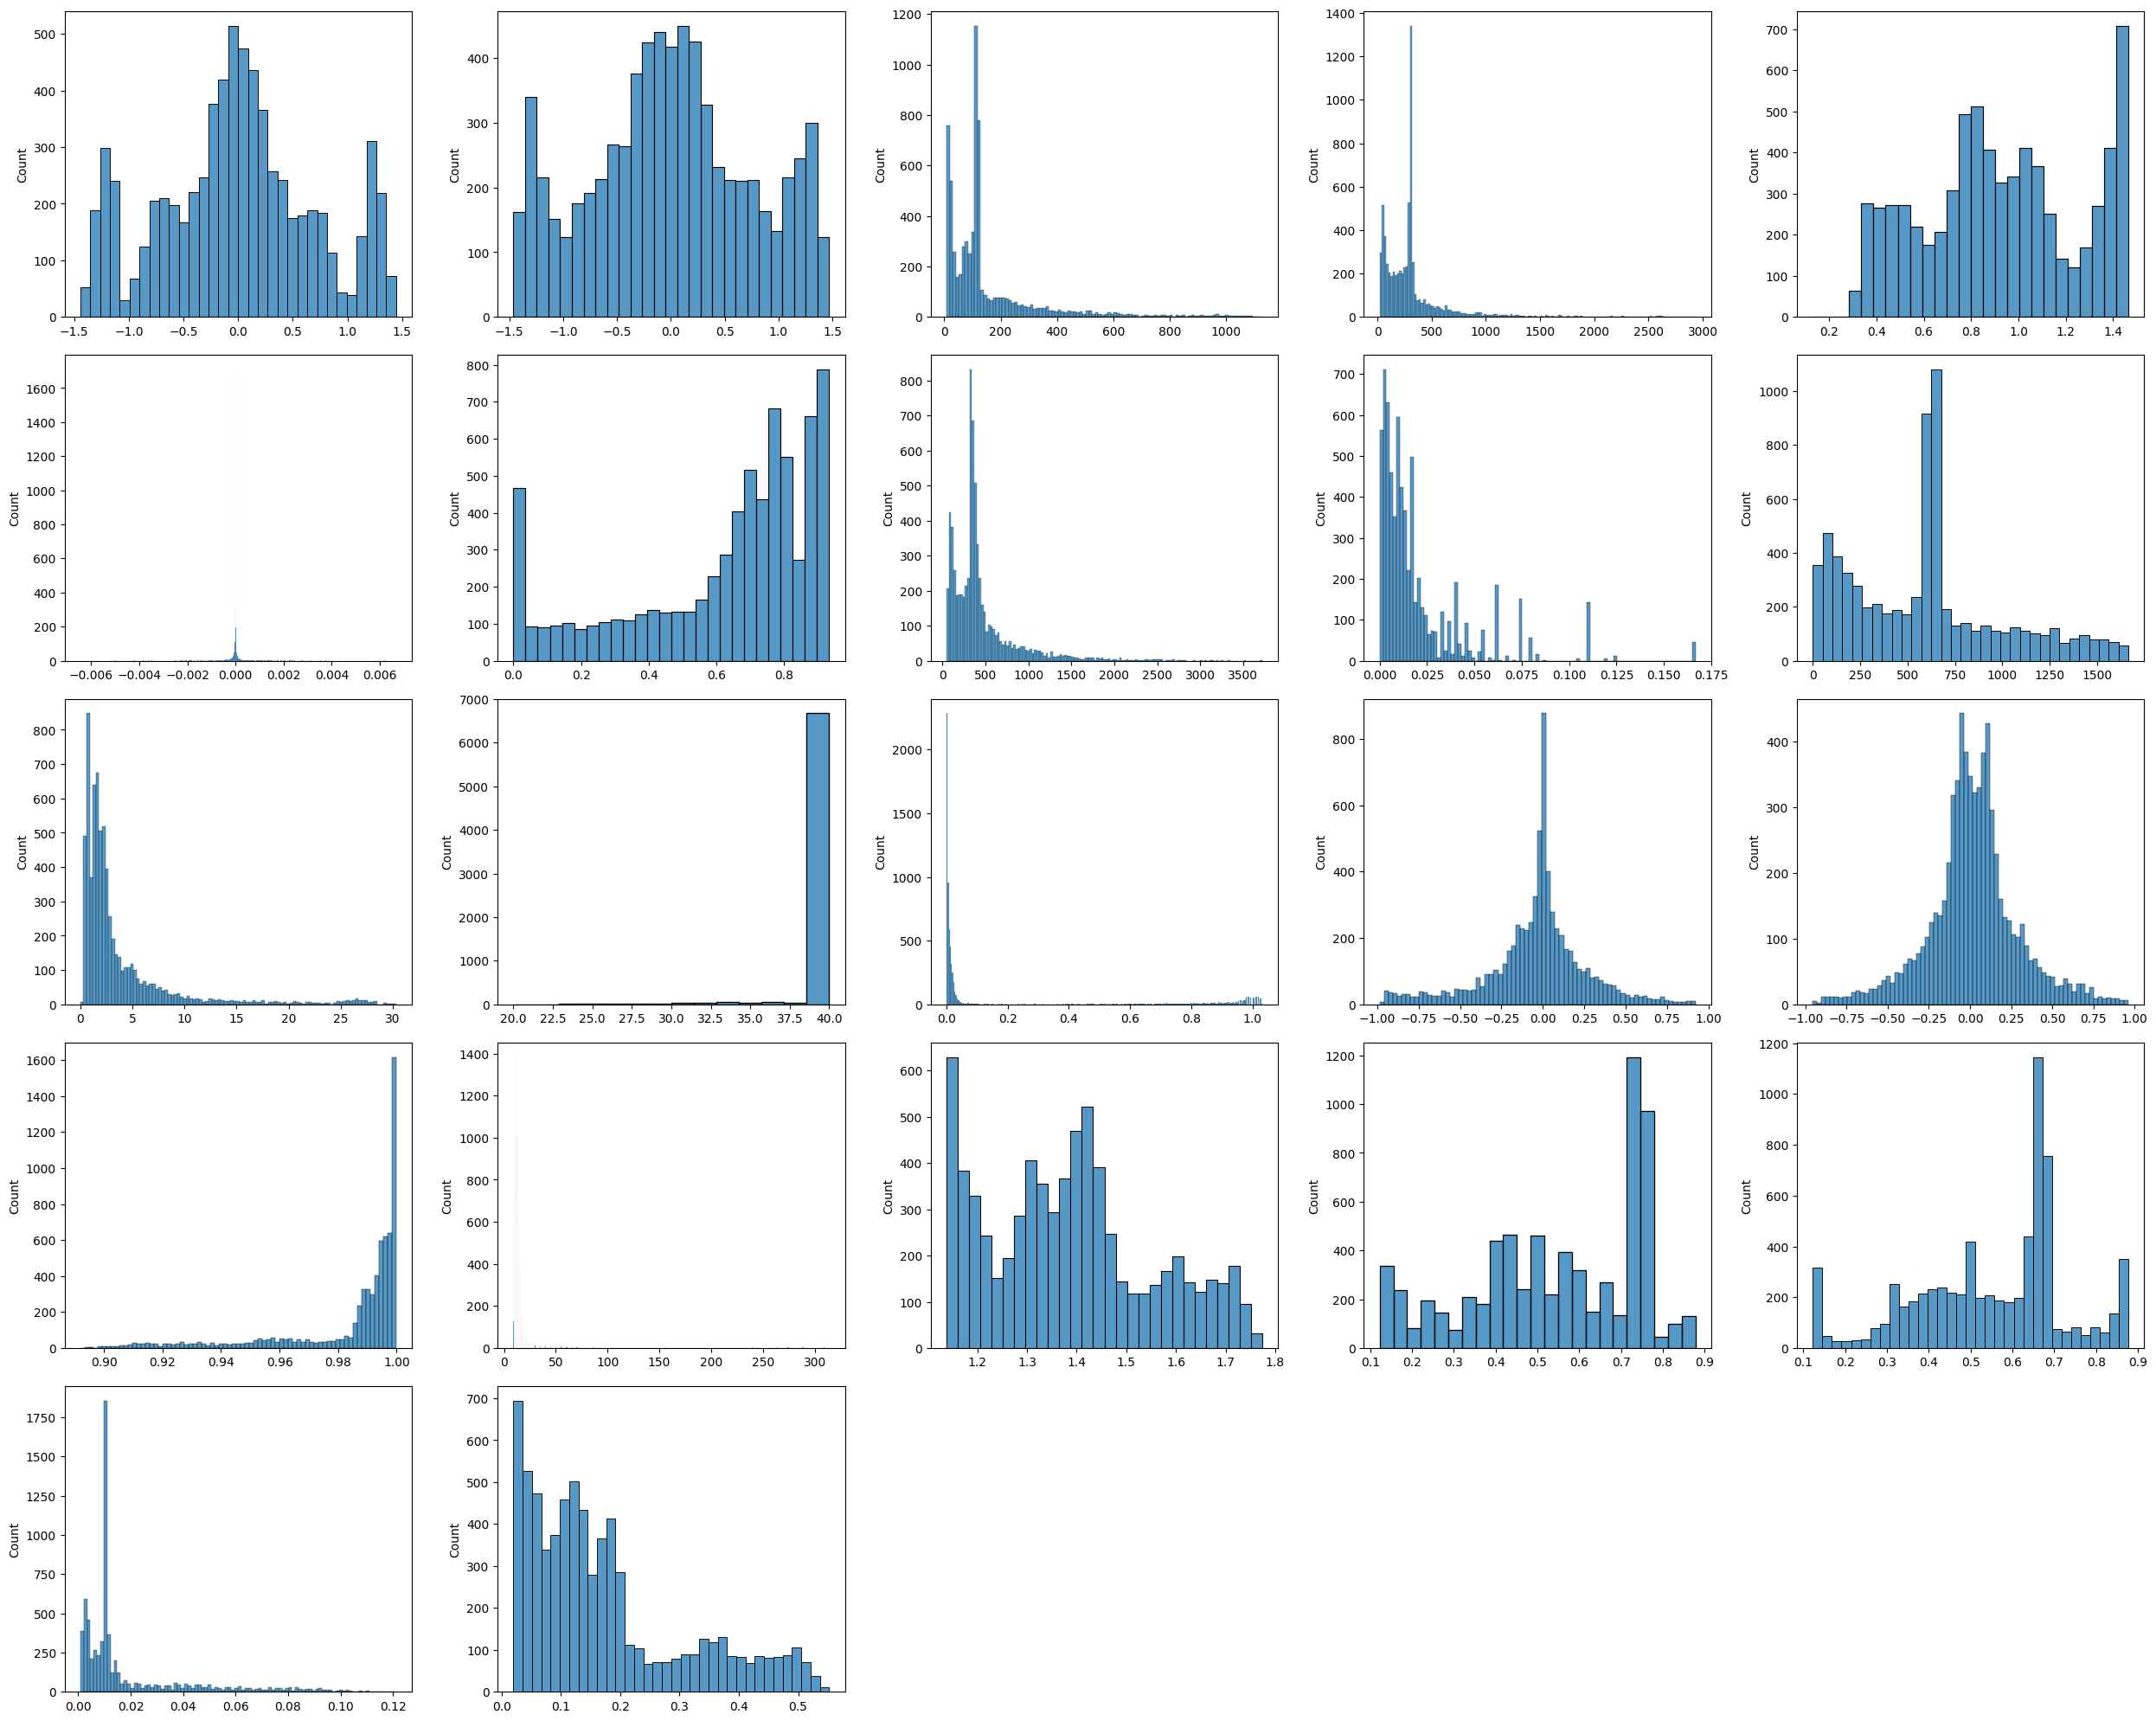

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(25, 20))
for index, ax in enumerate(axes.ravel()):
    if index > 21:
        ax.axis('off')
    else:
        sns.histplot(all_instances[:,index], ax=ax)
fig.tight_layout()

In [16]:
scaled_features = MixedSigmoid(all_instances)

In [308]:
rs = RobustScaler().fit(all_instances)
rs_fit = rs.transform(all_instances)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)

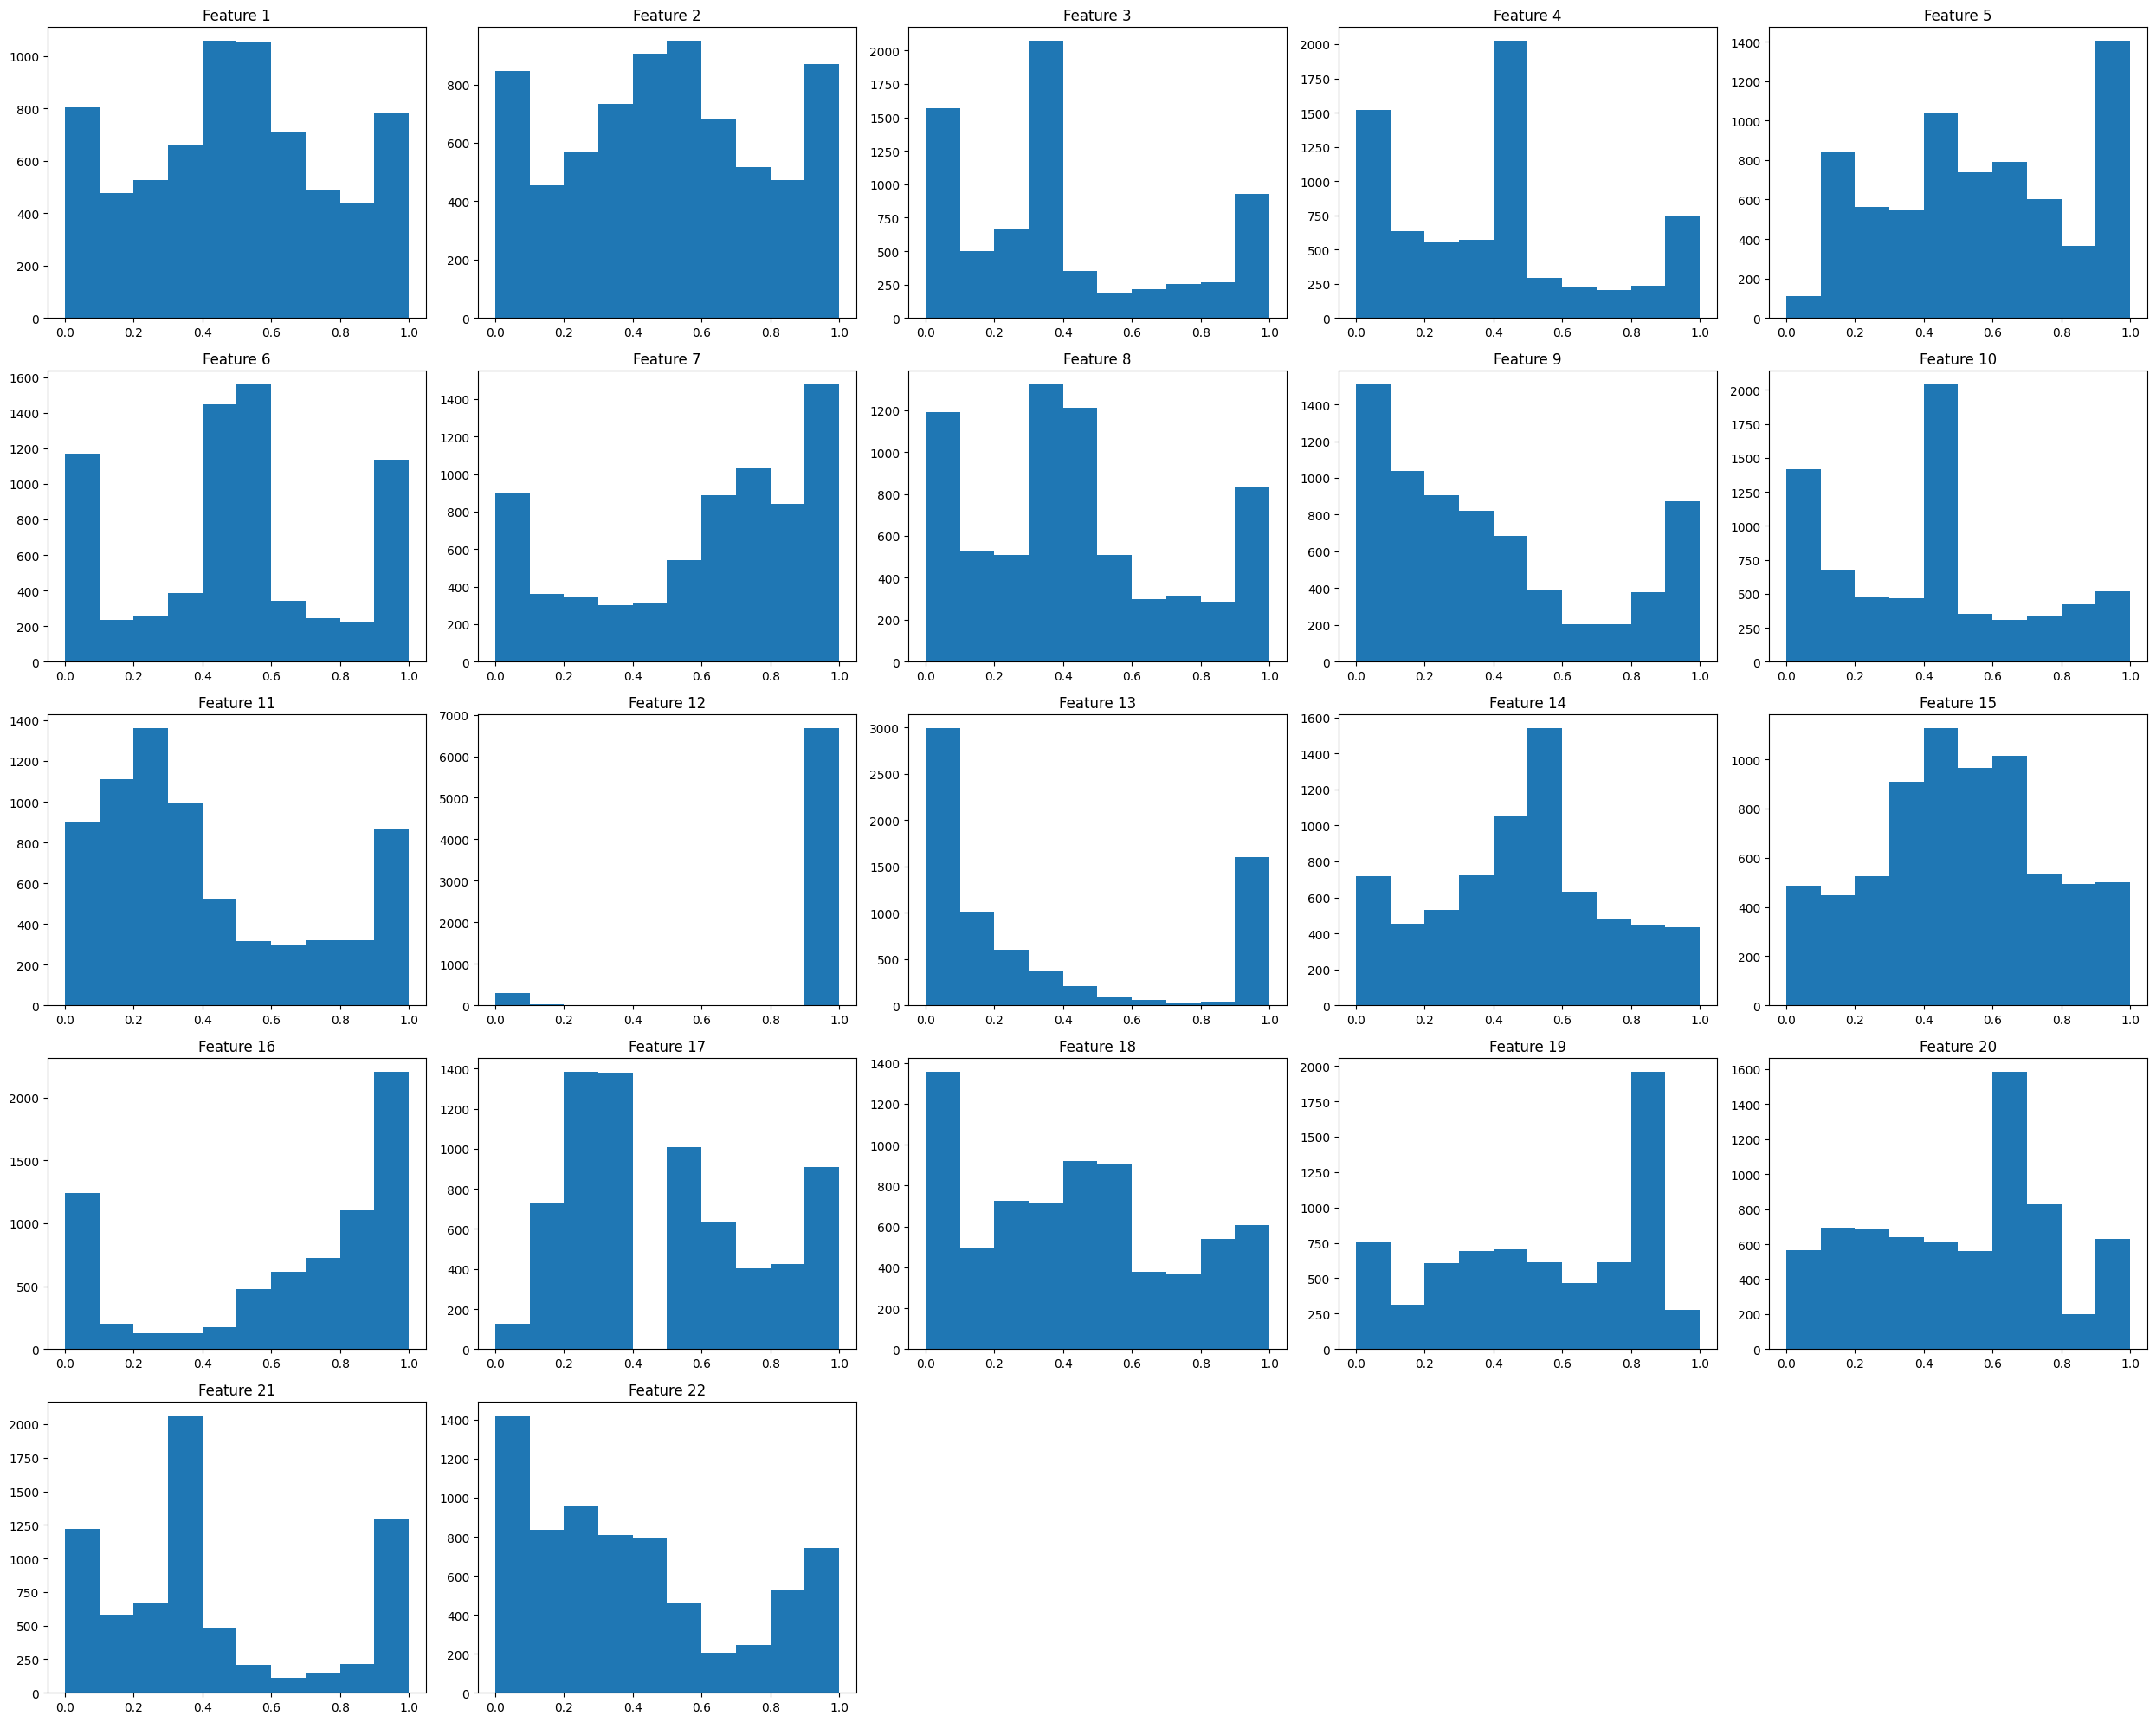

In [309]:
fig, axes = plt.subplots(5, 5, figsize=(25, 20))
for index, ax in enumerate(axes.ravel()):
    if index > 21:
        ax.axis('off')
    else:
        ax.hist(mm_fit[:,index])
        ax.set_title(f'Feature {index+1}')
fig.tight_layout()

In [310]:
pca = PCA(n_components=2).fit_transform(mm_fit)

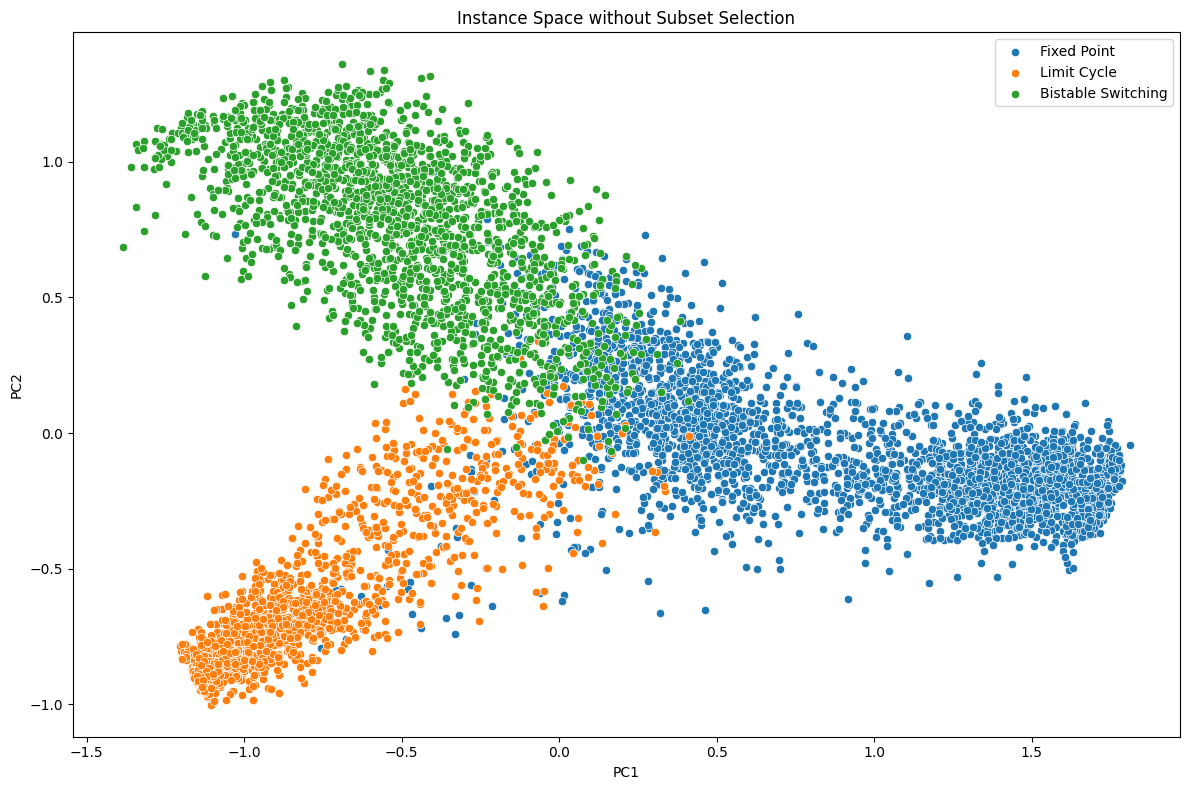

In [312]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca[:3000,0], y=pca[:3000,1], label='Fixed Point')
sns.scatterplot(x=pca[3000:5000,0], y=pca[3000:5000,1], label='Limit Cycle')
sns.scatterplot(x=pca[5000:,0], y=pca[5000:,1], label='Bistable Switching')
plt.title('Instance Space without Subset Selection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

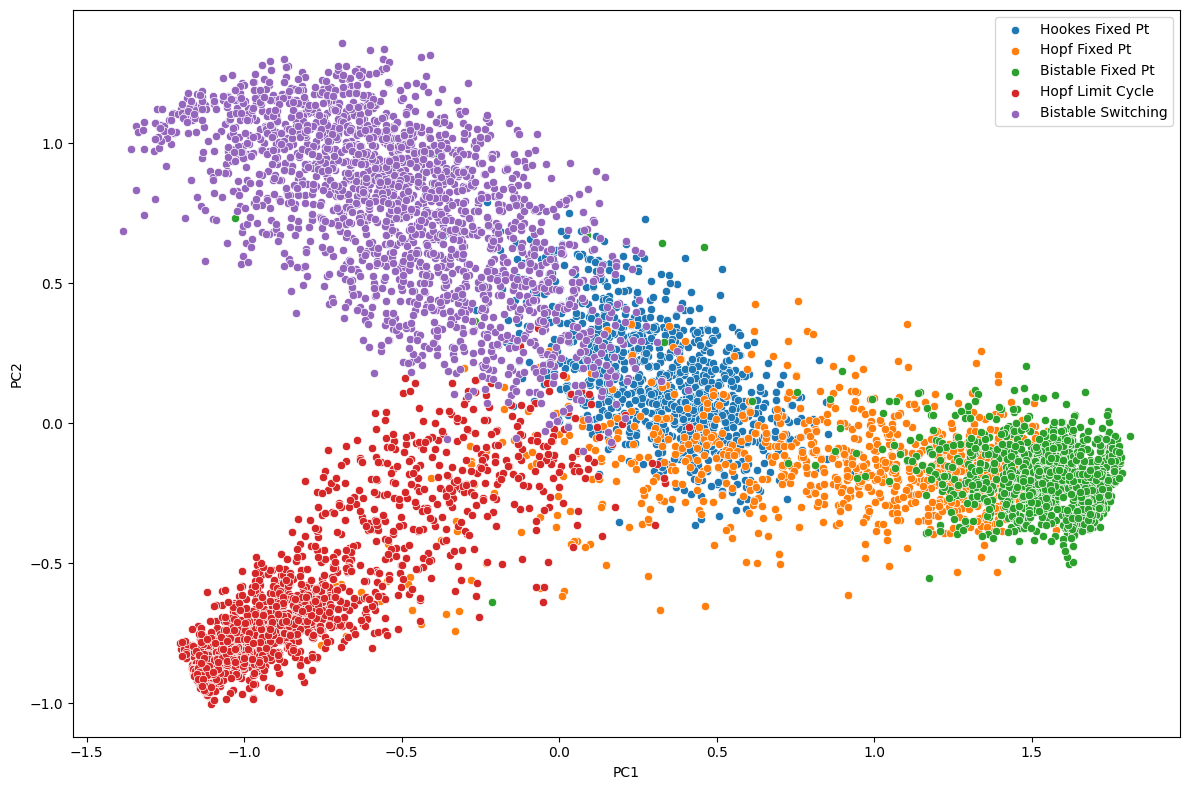

In [313]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca[:1000,0], y=pca[:1000,1], label='Hookes Fixed Pt ')
sns.scatterplot(x=pca[1000:2000,0], y=pca[1000:2000,1], label='Hopf Fixed Pt ')
sns.scatterplot(x=pca[2000:3000,0], y=pca[2000:3000,1], label='Bistable Fixed Pt')
sns.scatterplot(x=pca[3000:5000,0], y=pca[3000:5000,1], label='Hopf Limit Cycle')
sns.scatterplot(x=pca[5000:,0], y=pca[5000:,1], label='Bistable Switching')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

First attempt at confusion matrix based on euclidean distance

Matrix Diagonals

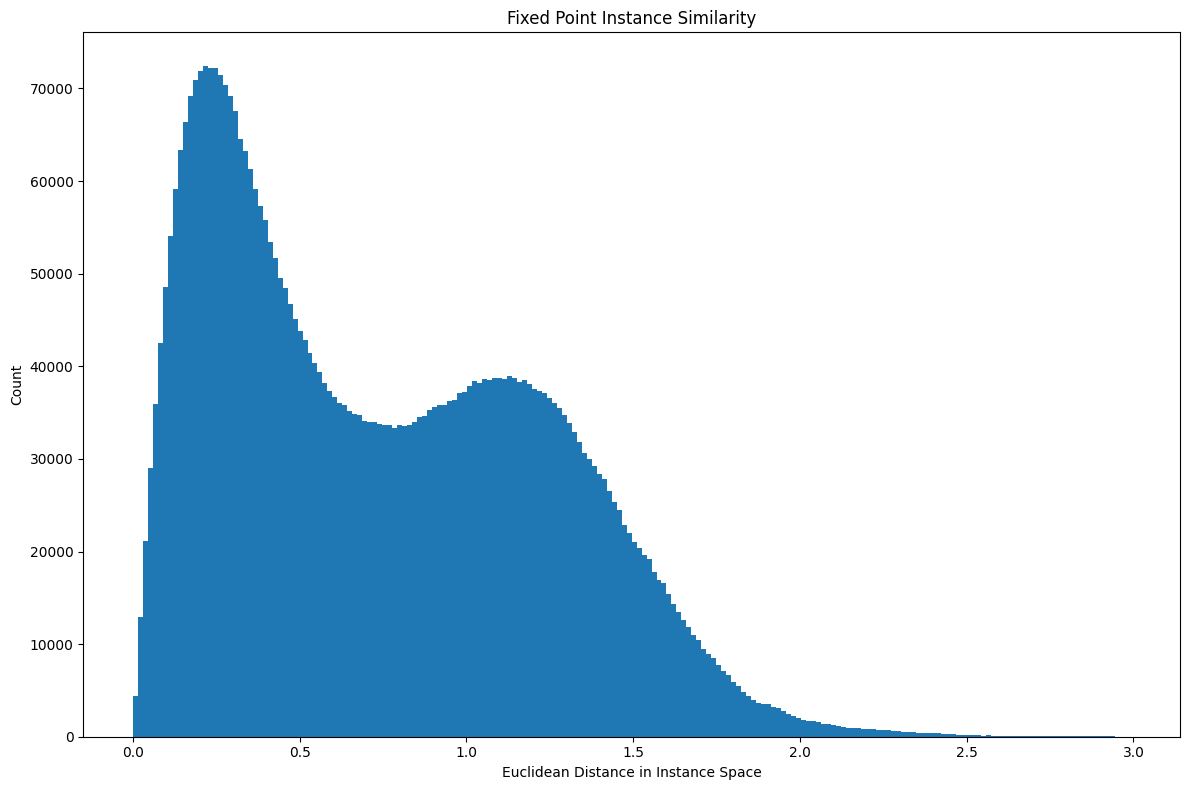

In [314]:
plt.figure(figsize=(12,8))
fixedpt = pdist(pca[:3000])
fixedpt = squareform(fixedpt) # convert to square matrix
#print(f'Symmetrical Matrix : {(fixedpt.transpose() == fixedpt).all()}')
fixedpt = np.triu(fixedpt) # take upper triangular part of the matrix since symmetrical (to avoid double counting for the histogram)
plt.hist(fixedpt[fixedpt != 0], bins=200)
plt.title('Fixed Point Instance Similarity')
plt.xlabel('Euclidean Distance in Instance Space')
plt.ylabel('Count')
plt.show()

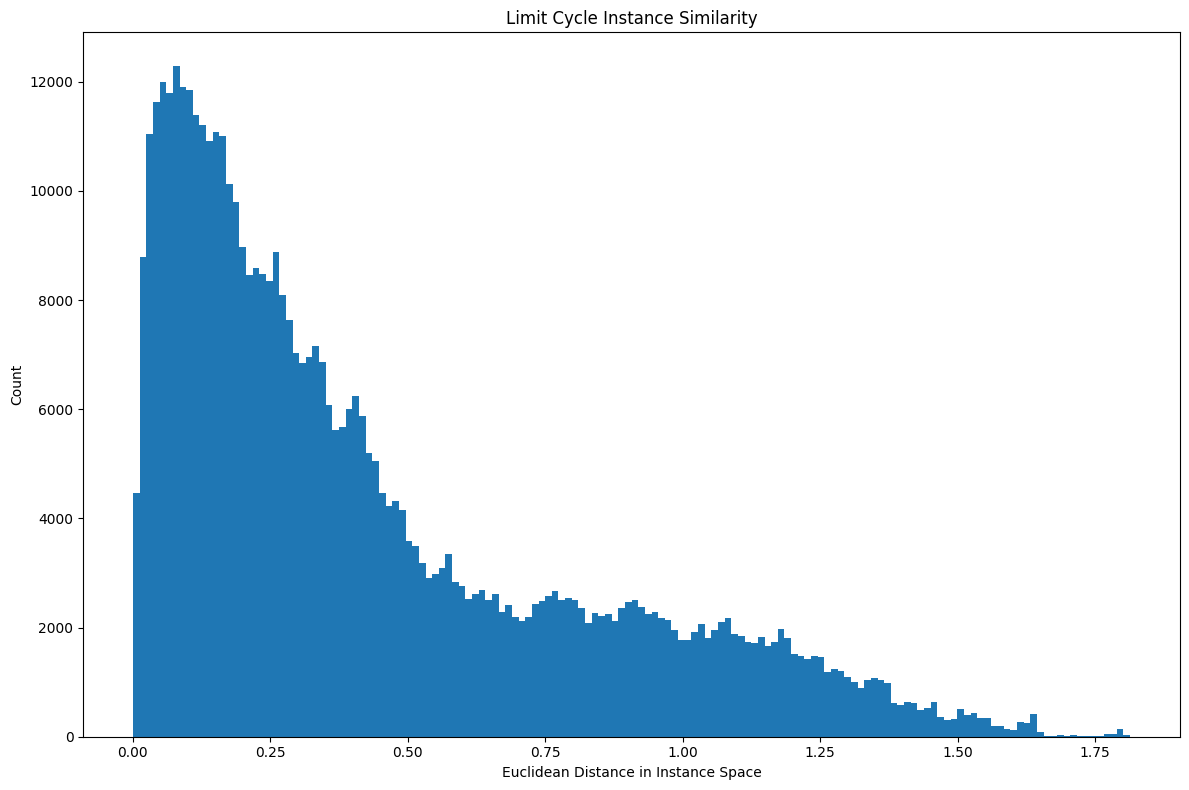

In [315]:
plt.figure(figsize=(12,8))
limitCycle = pdist(pca[3000:4000])
limitCycle = squareform(limitCycle) # convert to square matrix
#print(f'Symmetrical Matrix : {(fixedpt.transpose() == fixedpt).all()}')
limitCycle = np.triu(limitCycle) # take upper triangular part of the matrix since symmetrical (to avoid double counting for the histogram)
plt.hist(limitCycle[limitCycle != 0], bins=150)
plt.title('Limit Cycle Instance Similarity')
plt.xlabel('Euclidean Distance in Instance Space')
plt.ylabel('Count')
plt.show()

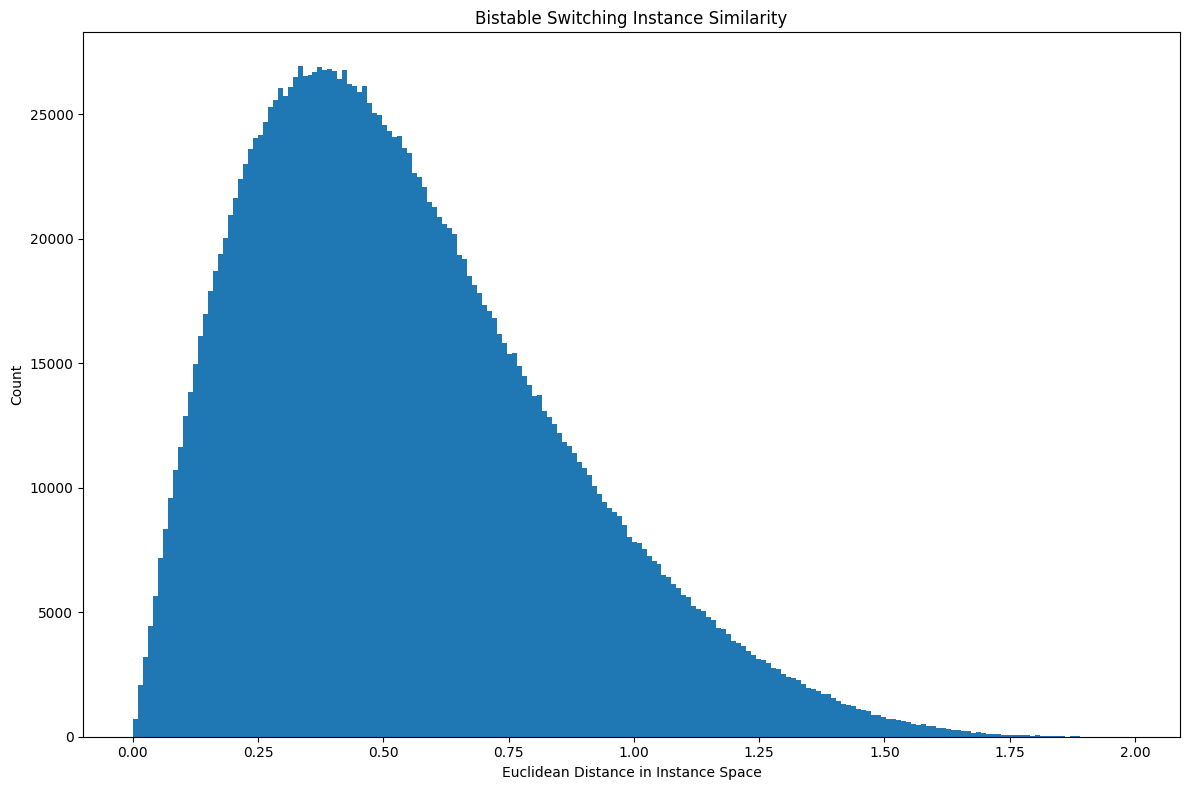

In [316]:
plt.figure(figsize=(12,8))
bistableSwitching = pdist(pca[5000:])
bistableSwitching = squareform(bistableSwitching) # convert to square matrix
#print(f'Symmetrical Matrix : {(fixedpt.transpose() == fixedpt).all()}')
bistableSwitching = np.triu(bistableSwitching) # take upper triangular part of the matrix since symmetrical (to avoid double counting for the histogram)
plt.hist(bistableSwitching[bistableSwitching != 0], bins=200)
plt.title('Bistable Switching Instance Similarity')
plt.xlabel('Euclidean Distance in Instance Space')
plt.ylabel('Count')
plt.show()

In [328]:
mean_lc = np.mean(limitCycle)
mean_bistable = np.mean(bistableSwitching)
mean_fixedpt = np.mean(fixedpt)
print(mean_lc, mean_bistable, mean_fixedpt)

0.21810436137975592 0.2734158825286482 0.3732139030498732


Matrix off-diagonal terms

In [340]:
lc_fp = cdist(pca[3000:5000], pca[:3000]) # limit cycle/fixed point
lc_sw = cdist(pca[3000:5000], pca[5000:]) # limit cycle / bistable switching
sw_fp = cdist(pca[5000:], pca[:3000]) # bistable switching / fixed pt

mean_lc_fp = np.mean(lc_fp)
mean_lc_sw = np.mean(lc_sw)
mean_sw_fp = np.mean(sw_fp)
print(mean_lc_fp, mean_lc_sw, mean_sw_fp)

1.9456574653032022 1.5742065419228748 1.7050108691180013


In [341]:
similarity_matrix = np.array([[mean_fixedpt, mean_lc_fp, mean_sw_fp], [mean_lc_fp, mean_lc, mean_lc_sw], [mean_sw_fp, mean_lc_sw, mean_bistable]])
similarity_matrix

array([[0.3732139 , 1.94565747, 1.70501087],
       [1.94565747, 0.21810436, 1.57420654],
       [1.70501087, 1.57420654, 0.27341588]])

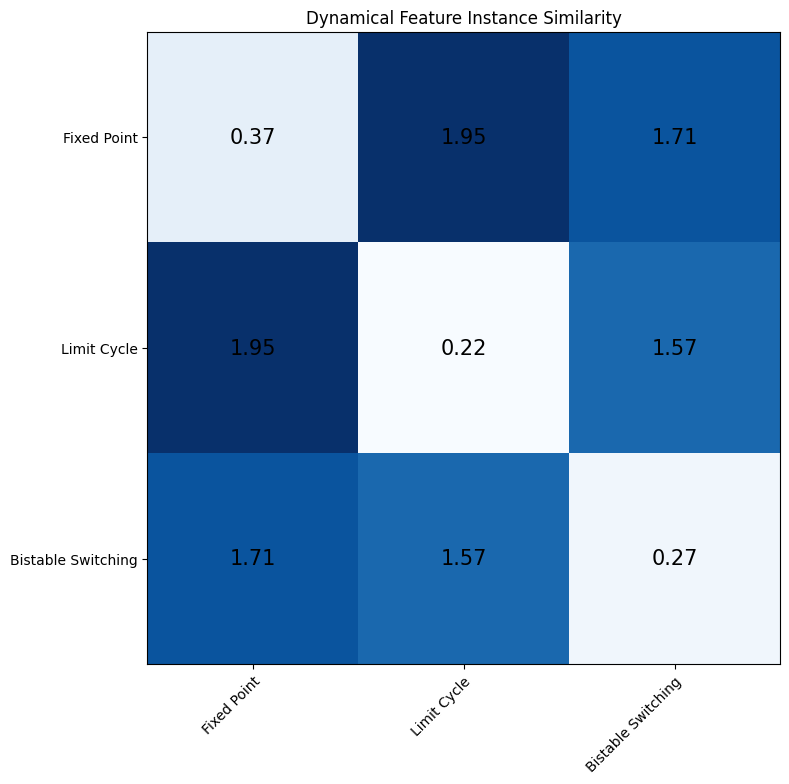

In [320]:
labels = ['Fixed Point', 'Limit Cycle', 'Bistable Switching']
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(similarity_matrix, cmap='Blues')
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha="center", va="center", fontsize=15)

ax.set_title("Dynamical Feature Instance Similarity")
fig.tight_layout()
#plt.savefig('dist_matrix.svg')
plt.show()

Aim to wrap all the distance calculations into a single function which spits out a matrix and/or plot. This will make it easier for optimisation later on. 

Adding back in the subset selection method...

In [75]:
def select_representative_instances(subset_target_size, ts, df, x0=0.01):
    # takes in target number of instances, uses hierarchical clustering to find most representative samples
    # returns dataframe and ts of selected subset
    # x0 is the initial guess for fsolve
    normalized_features = StandardScaler().fit_transform(df.iloc[:,:22]) # extract the features from df and standardise
    Z = linkage(normalized_features, method='ward')
    def calc_clusters(max_d):
        clusters = fcluster(Z, max_d, criterion='distance')
        num_clusters = np.max(clusters)
        return subset_target_size - num_clusters
    res = fsolve(calc_clusters, x0=x0)
    clusters = fcluster(Z, res, criterion='distance')
    num_clusters = np.max(clusters)
    subset_index = list() # store indicies of the selected instances from each cluster
    for i in range(1, num_clusters+1):
        cluster_indicies = np.argwhere(clusters == i).reshape(-1,) # get all samples in each cluster
        if len(cluster_indicies) > 1:
            # select the most representative instance that minimizes sum of pairwise distances
            ary = cdist(df.iloc[cluster_indicies, :22], df.iloc[cluster_indicies, :22], metric='euclidean')
            most_representative = np.sum(ary, axis=1).argmin()
            most_rep_index = cluster_indicies[most_representative]
        else:
            most_rep_index = cluster_indicies.reshape(-1,)[0]
        subset_index.append(most_rep_index)
    # reduced ts and df for the selected subset
    ts_reduced = ts[subset_index]
    df_reduced = df.iloc[subset_index] # retains original index number
    
    return ts_reduced, df_reduced

In [321]:
fp_ts_subset, fp_df_subset = select_representative_instances(1000, ts_fixedpt, df_fixedpt, 0.1)
lc_ts_subset, lc_df_subset = select_representative_instances(1000, ts_hopflc, df_hopflc)
sw_ts_subset, sw_df_subset = select_representative_instances(1000, ts_switching, df_switching, 0.1)

In [322]:
all_instances_subset = np.vstack([fp_df_subset.iloc[:,:22], lc_df_subset.iloc[:,:22], sw_df_subset.iloc[:,:22]])

In [323]:
rs = RobustScaler().fit(all_instances_subset)
rs_fit = rs.transform(all_instances_subset)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit_subset = mm.transform(sigmoid_fit)

In [324]:
scaledSigmoid= MixedSigmoid(all_instances_subset)

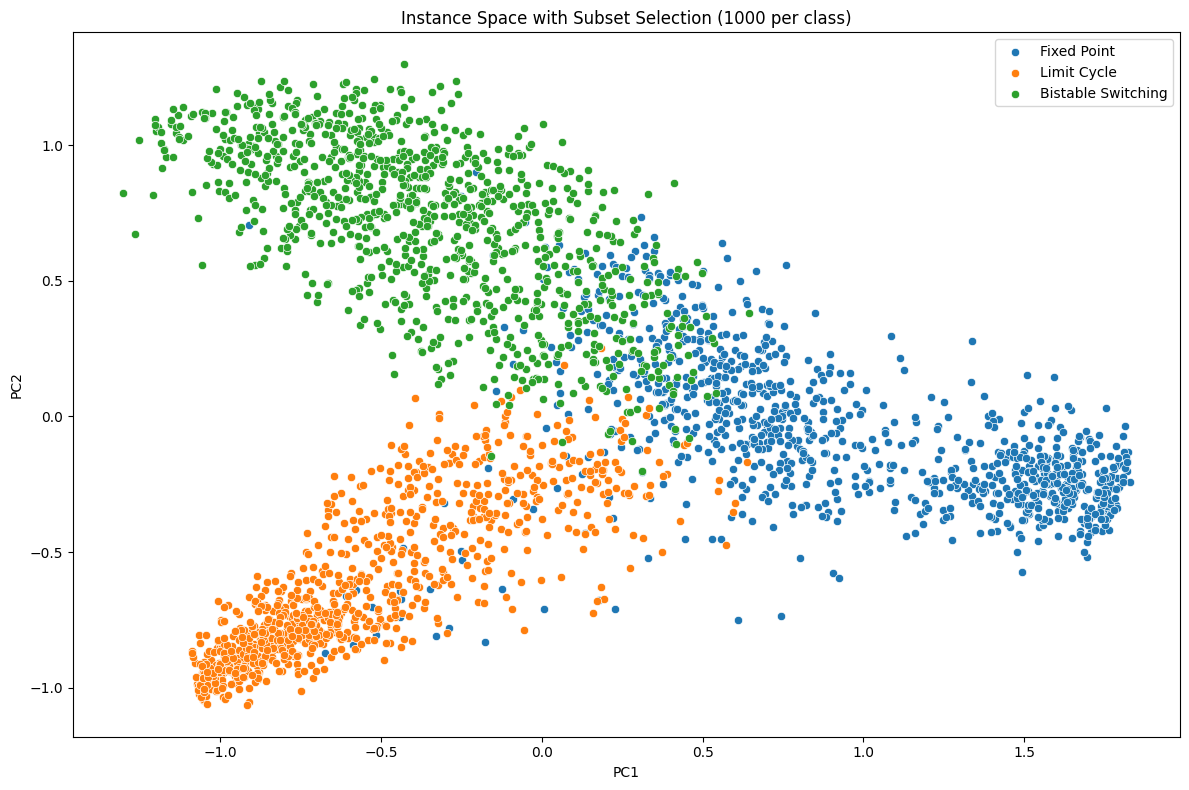

In [373]:
plt.figure(figsize=(12,8))
pca_subset_transformer = PCA(n_components=2).fit(mm_fit_subset)
pca_subset = pca_subset_transformer.transform(mm_fit_subset)
sns.scatterplot(x=pca_subset[:1000,0], y=pca_subset[:1000,1], label='Fixed Point')
sns.scatterplot(x=pca_subset[1000:2000,0], y=pca_subset[1000:2000,1], label='Limit Cycle')
sns.scatterplot(x=pca_subset[2000:,0], y=pca_subset[2000:,1], label='Bistable Switching')
plt.title('Instance Space with Subset Selection (1000 per class)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [357]:
# on-diagonal terms
mean_fp_subset = statistics.median(pdist(pca_subset[:1000]))
mean_lc_subset = statistics.median(pdist(pca_subset[1000:2000]))
mean_sw_subset = statistics.median(pdist(pca_subset[2000:]))

# off-diagonal terms
mean_fp_lc_subset = statistics.median(cdist(pca_subset[:1000], pca_subset[1000:2000]).ravel())
mean_fp_sw_subset = statistics.median(cdist(pca_subset[:1000], pca_subset[2000:]).ravel())
mean_lc_sw_subset = statistics.median(cdist(pca_subset[1000:2000], pca_subset[2000:]).ravel())

# construct matrix 
similarity_matrix_subset = np.array([[mean_fp_subset, mean_fp_lc_subset, mean_fp_sw_subset], [mean_fp_lc_subset, mean_lc_subset, mean_lc_sw_subset], [mean_fp_sw_subset, mean_lc_sw_subset, mean_sw_subset]])
print(similarity_matrix_subset)

[[0.70476598 1.75305091 1.58044686]
 [1.75305091 0.47001748 1.55030739]
 [1.58044686 1.55030739 0.55643254]]


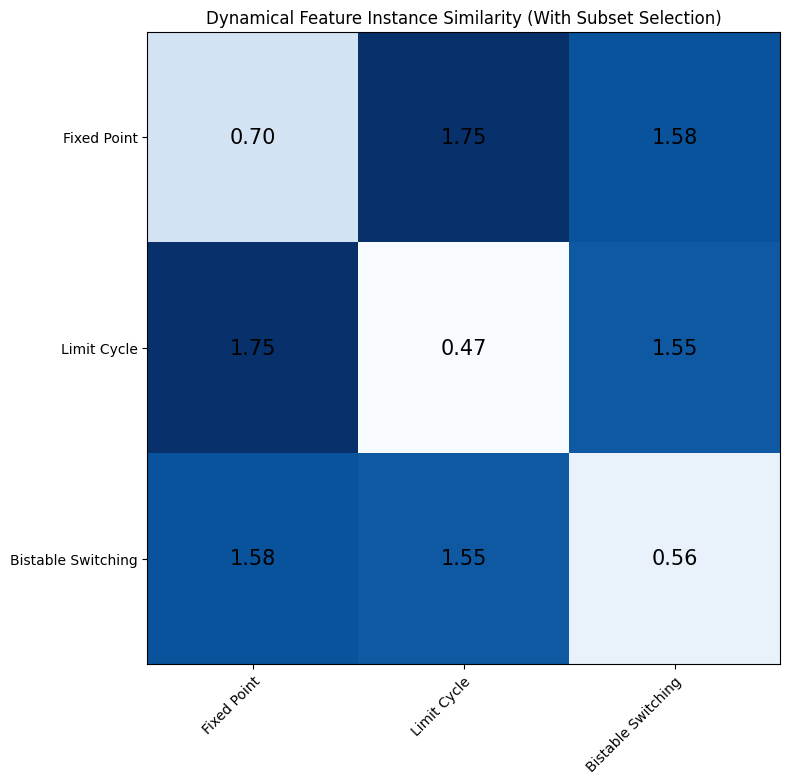

In [359]:
labels = ['Fixed Point', 'Limit Cycle', 'Bistable Switching']
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(similarity_matrix_subset, cmap='Blues')
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{similarity_matrix_subset[i, j]:.2f}',
                       ha="center", va="center", fontsize=15)

ax.set_title("Dynamical Feature Instance Similarity (With Subset Selection)")
fig.tight_layout()
#plt.savefig('dist_matrix.svg')
plt.show()

Quick test with subset instance space...

In [942]:
test_ts, test_df = gen_limitCycle(1)

Generating Limit Cycle Instances...
0/1


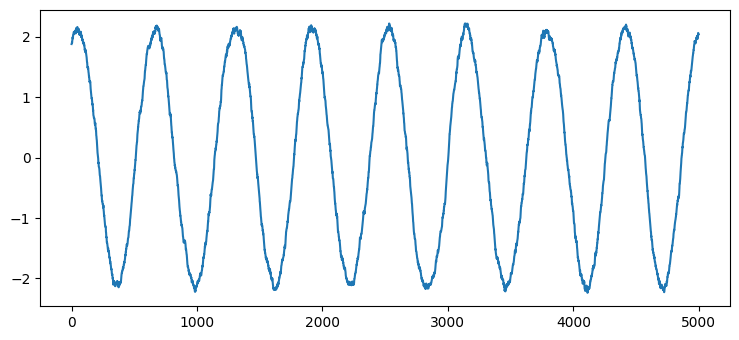

In [943]:
plt.plot(test_ts[0])

In [944]:
test_embeddings = pca_subset_transformer.transform(mm.transform(sigmoid_transformer.transform(rs.transform(test_df.iloc[:,:22]))))

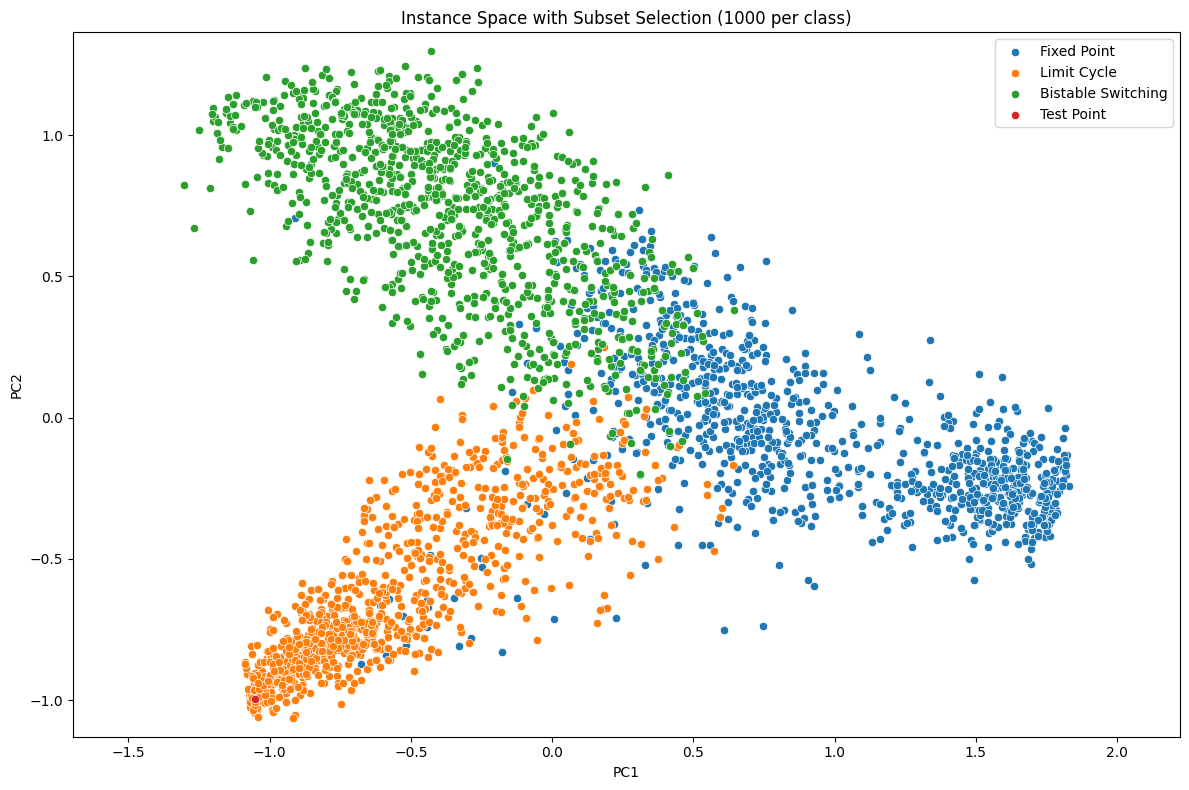

In [945]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca_subset[:1000,0], y=pca_subset[:1000,1], label='Fixed Point')
sns.scatterplot(x=pca_subset[1000:2000,0], y=pca_subset[1000:2000,1], label='Limit Cycle')
sns.scatterplot(x=pca_subset[2000:,0], y=pca_subset[2000:,1], label='Bistable Switching')
sns.scatterplot(x=test_embeddings[:, 0], y=test_embeddings[:,1], label='Test Point')
plt.title('Instance Space with Subset Selection (1000 per class)')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Confusion matrix for instance space evaluation on unseen data

In [824]:
# get indices of points within radius, use indices to extract corresponding system labels and do inference
# project test point
X, Y = test_embeddings[0]
labels_encoding = np.concatenate([np.tile(0, 1000), np.tile(1, 1000), np.tile(2, 1000)]) # 0 = FP, 1 = LC, 2 = BS

In [825]:
R = 0.7 # ABC threshold value
neighbours = np.argwhere((pca_subset[:,0] - X)**2 + (pca_subset[:,1] - Y)**2 < R**2)
neighbours = labels_encoding[neighbours]

In [826]:
unique, counts = np.unique(neighbours, return_counts=True)
density = np.zeros((1, 3)) # index 0 = FP, index 1 = LC, index 2 = BS
for index, val in enumerate(unique):
    density[0, val] = counts[index]

In [827]:
density /= np.sum(density) # normalize for probability


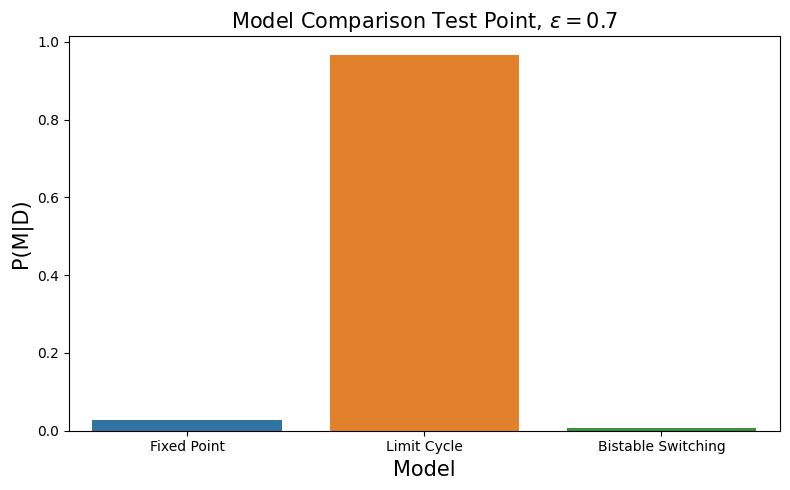

In [828]:
fig = plt.figure(figsize=(8,5))
plt.ylabel('P(M|D)', fontsize=15)
plt.xlabel('Model', fontsize=15)
models = ['Fixed Point', 'Limit Cycle', 'Bistable Switching']
plt.title('Model Comparison Test Point, $\epsilon = 0.7$', fontsize=15)
sns.barplot(x=models, y=density[0])
plt.show()

## LDA Supervised Approach to Instance Space Calibration

In [409]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [417]:
labels_encoding = np.concatenate([np.tile(0, 1000), np.tile(1, 1000), np.tile(2, 1000)]) # 0 = FP, 1 = LC, 2 = BS

In [443]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(mm_fit_subset, labels_encoding)
lda_embeddings = lda.transform(mm_fit_subset)

In [458]:
# add in mu, eta and regime information for model comparison and selection
lda_embeddings_full_df = pd.DataFrame(lda_embeddings)
lda_embeddings_full_df['system'] = labels_encoding

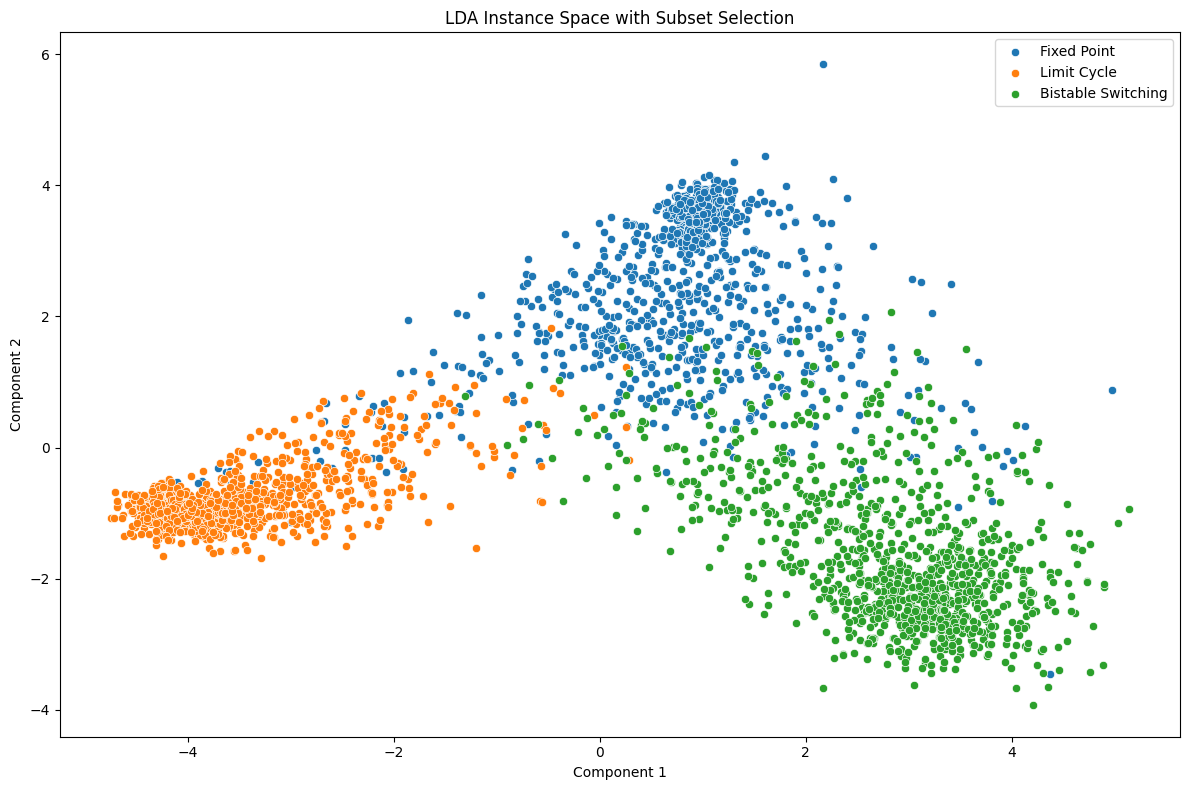

In [444]:
plt.figure(figsize=(12,8))
plt.title('LDA Instance Space with Subset Selection')
sns.scatterplot(x=lda_embeddings[:1000, 0], y=lda_embeddings[:1000, 1], label='Fixed Point')
sns.scatterplot(x=lda_embeddings[1000:2000, 0], y=lda_embeddings[1000:2000, 1], label='Limit Cycle')
sns.scatterplot(x=lda_embeddings[2000:, 0], y=lda_embeddings[2000:, 1], label='Bistable Switching')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Compute similarity matrix for LDA instance space

In [445]:
# on-diagonal terms
mean_fp_subset = statistics.median(pdist(lda_embeddings[:1000]))
mean_lc_subset = statistics.median(pdist(lda_embeddings[1000:2000]))
mean_sw_subset = statistics.median(pdist(lda_embeddings[2000:]))

# off-diagonal terms
mean_fp_lc_subset = statistics.median(cdist(lda_embeddings[:1000], lda_embeddings[1000:2000]).ravel())
mean_fp_sw_subset = statistics.median(cdist(lda_embeddings[:1000], lda_embeddings[2000:]).ravel())
mean_lc_sw_subset = statistics.median(cdist(lda_embeddings[1000:2000], lda_embeddings[2000:]).ravel())

# construct matrix 
similarity_matrix_subset = np.array([[mean_fp_subset, mean_fp_lc_subset, mean_fp_sw_subset], [mean_fp_lc_subset, mean_lc_subset, mean_lc_sw_subset], [mean_fp_sw_subset, mean_lc_sw_subset, mean_sw_subset]])
print(similarity_matrix_subset)

[[1.69783124 5.80740166 5.00784931]
 [5.80740166 0.81833746 6.72320549]
 [5.00784931 6.72320549 1.5685942 ]]


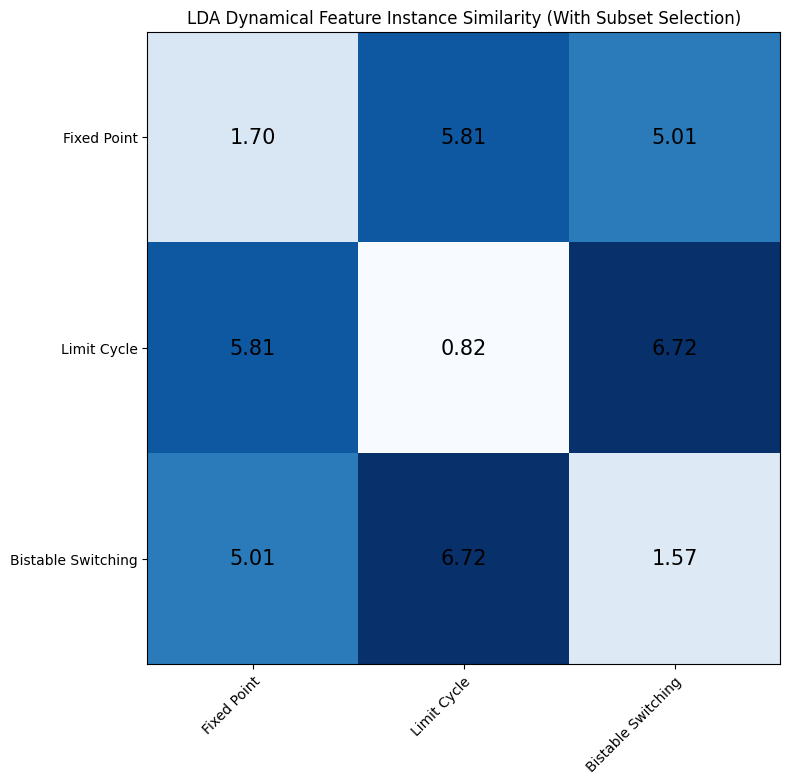

In [446]:
labels = ['Fixed Point', 'Limit Cycle', 'Bistable Switching']
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(similarity_matrix_subset, cmap='Blues')
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{similarity_matrix_subset[i, j]:.2f}',
                       ha="center", va="center", fontsize=15)

ax.set_title("LDA Dynamical Feature Instance Similarity (With Subset Selection)")
fig.tight_layout()
#plt.savefig('dist_matrix.svg')
plt.show()

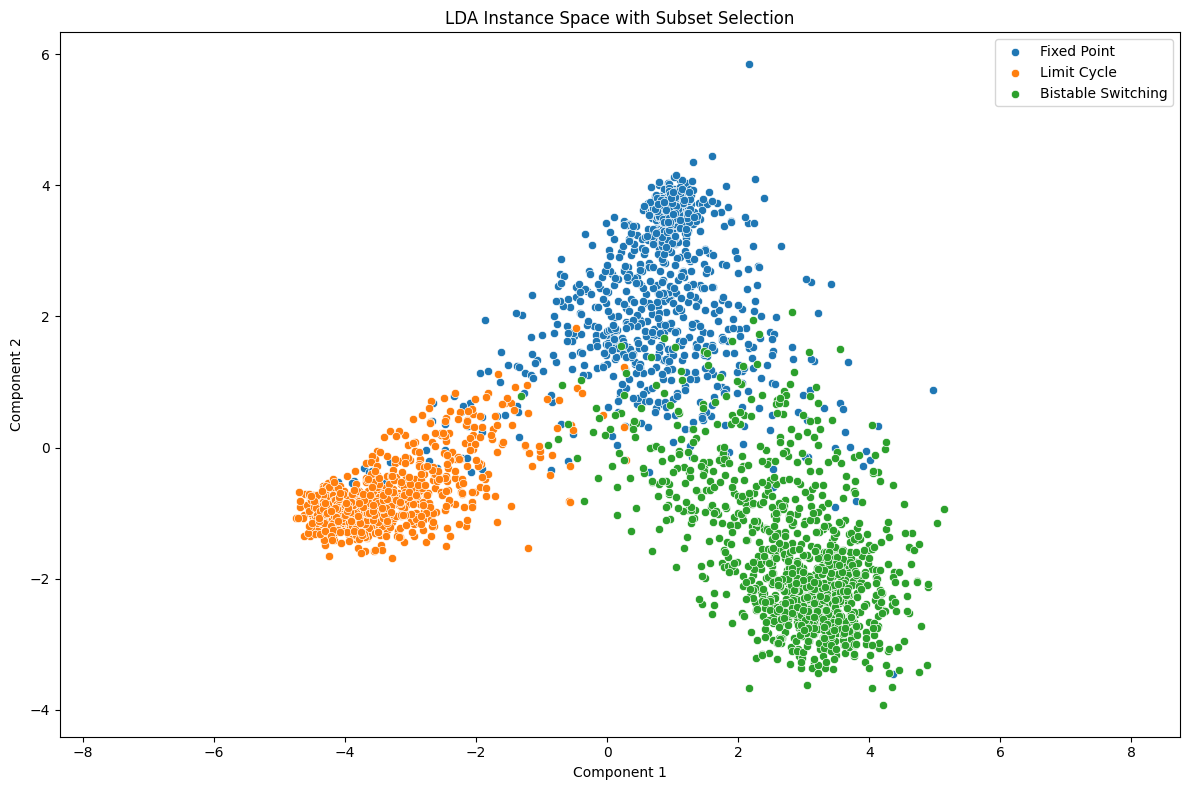

In [467]:
plt.figure(figsize=(12,8))
plt.title('LDA Instance Space with Subset Selection')
sns.scatterplot(x=lda_embeddings[:1000, 0], y=lda_embeddings[:1000, 1], label='Fixed Point')
sns.scatterplot(x=lda_embeddings[1000:2000, 0], y=lda_embeddings[1000:2000, 1], label='Limit Cycle')
sns.scatterplot(x=lda_embeddings[2000:, 0], y=lda_embeddings[2000:, 1], label='Bistable Switching')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.axis('equal')
plt.show()

Evaluation with new instances

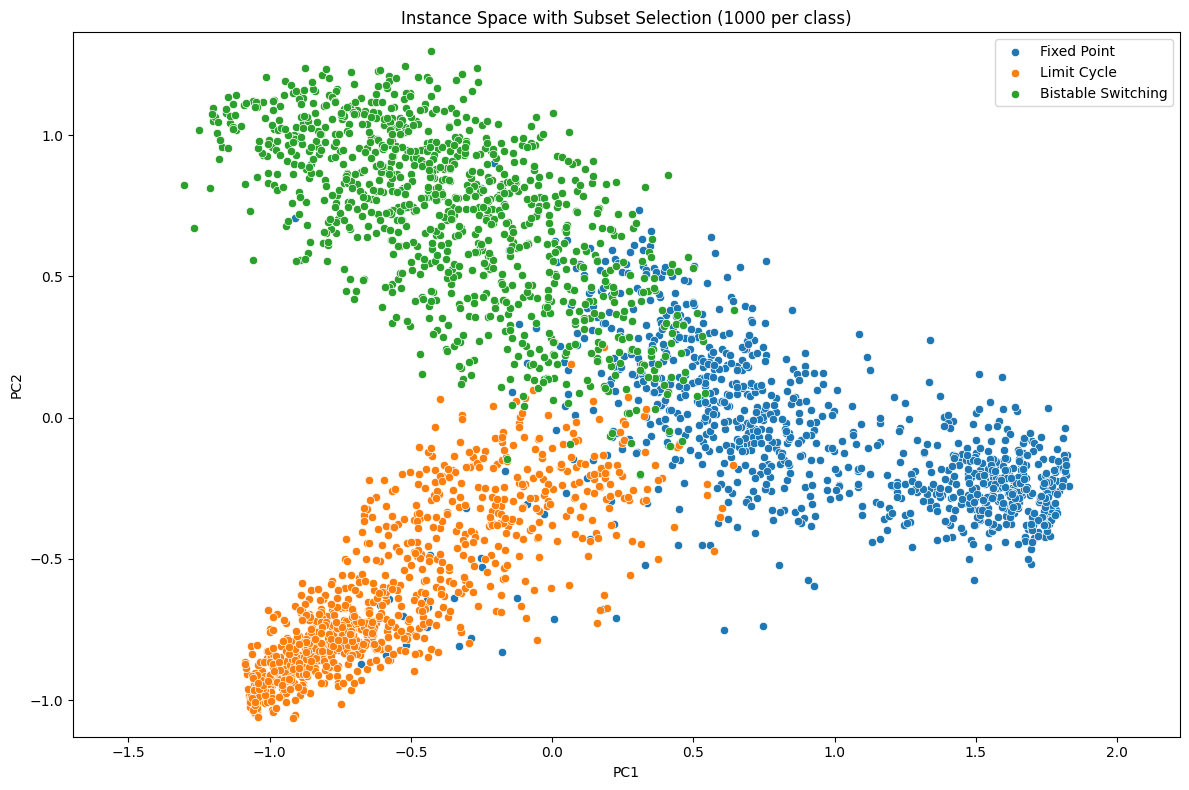

In [1058]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca_subset[:1000,0], y=pca_subset[:1000,1], label='Fixed Point')
sns.scatterplot(x=pca_subset[1000:2000,0], y=pca_subset[1000:2000,1], label='Limit Cycle')
sns.scatterplot(x=pca_subset[2000:,0], y=pca_subset[2000:,1], label='Bistable Switching')
plt.title('Instance Space with Subset Selection (1000 per class)')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [1067]:
ts_eval_lc, df_eval_lc = gen_limitCycle(100)
ts_eval_fp, df_eval_fp = gen_fixedpoint(100)
ts_eval_sw, df_eval_sw = gen_switching(100)

Generating Limit Cycle Instances...
0/100
Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...
Loading Filter...
Generating Bistable Switching Instances...


In [1068]:
df_eval = pd.concat([df_eval_lc, df_eval_fp, df_eval_sw])

In [1069]:
eval_embeddings = pca_subset_transformer.transform(mm.transform(sigmoid_transformer.transform(rs.transform(df_eval.iloc[:,:22]))))

#### New approach to sampling bistable system (non M.L. approach)

In [1105]:
# 1. Generate bistable instance using randomly sample mu and eta as usual
# 2. Compute fixed points for current mu value and compute range as diff between two fixed points -> threshold
# 3. Compute difference between min and max for given instance, compare to threshold
# 4. If difference is equal to or greater than threshold, then accept as "bistable", else reject and sample again 

In [1180]:
x = smp.Symbol('x', real=True)
eq = -0.38 + x - x**3
roots = [i.n(6) for i in real_roots(eq, x)]
roots

[-1.15306, 0.523311, 0.629753]

obtain new limits for bistable region

In [1205]:
mus = np.linspace(-0.4, 0.4, 10000)
roots_store = np.zeros(len(mus))
for index, mu in enumerate(mus):
    x = smp.Symbol('x', real=True)
    eq = mu + x - x**3
    roots = [i.n(6) for i in real_roots(eq, x)]
    roots_store[index] = (len(roots))

In [1211]:
first = mus[np.argwhere(roots_store == 3)[0]]
last = mus[np.argwhere(roots_store == 3)[-1]]
print(first, last) # should be the same by symmetry

[-0.38487849] [0.38487849]


In [1303]:
eta_val_bistable = 0.5
mu_val_bistable = -0.37
sols_list = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
mu = np.random.uniform(-0.384, 0.384)
eta = np.random.uniform(0.2, 1)
def f(state, t):
    x = state
    dxdt = mu + x - x**3
    return dxdt
ic = np.array([np.random.uniform()])
gw = lambda y, t: eta * np.identity(ic.shape[0])
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
sols_list.append(sol[500:])

In [1304]:
x = smp.Symbol('x', real=True)
eq = -0.37 + x - x**3
roots = [i.n(6) for i in real_roots(eq, x)]
max_root = np.max(roots)
min_root = np.min(roots)
print(max_root, min_root)

0.667771 -1.14970


In [1305]:
max_actual = np.max(sols_list[0])
min_actual = np.min(sols_list[0])
print(max_actual, min_actual)

1.365740071986575 -1.6056188094984087


In [1306]:
if (max_actual >= max_root) & (min_actual <= min_root):
    print('Bistable')
else:
    print('Not Bistable')

Bistable


In [1367]:
def gen_switching(num_samples):
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    count = 0 
    while count < num_samples:
        mu = np.random.uniform(low=-0.38487849, high=0.38487849)
        eta = np.random.uniform(0.001, 1)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (max_actual >= max_root) & (min_actual <= min_root):
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list.append(sol[500:])
            count += 1
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'BistableSW'
    return ts_bistable, df

In [1368]:
ts_switching, df_switching = gen_switching(2000)

In [1392]:
ts_hopflc, df_hopflc = gen_limitCycle(2000)

Generating Limit Cycle Instances...
0/5000
100/5000
200/5000
300/5000
400/5000
500/5000
600/5000
700/5000
800/5000
900/5000
1000/5000
1100/5000
1200/5000
1300/5000
1400/5000
1500/5000
1600/5000
1700/5000
1800/5000
1900/5000
2000/5000
2100/5000
2200/5000
2300/5000
2400/5000
2500/5000
2600/5000
2700/5000
2800/5000
2900/5000
3000/5000
3100/5000
3200/5000
3300/5000
3400/5000
3500/5000
3600/5000
3700/5000
3800/5000
3900/5000
4000/5000
4100/5000
4200/5000
4300/5000
4400/5000
4500/5000
4600/5000
4700/5000
4800/5000
4900/5000


In [1541]:
ts_fixedpt, df_fixedpt = gen_fixedpoint(2000) # use even numbers

Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...


In [1542]:
sw_ts_subset, sw_df_subset = select_representative_instances(1000, ts_switching, df_switching, 0.1)
lc_ts_subset, lc_df_subset = select_representative_instances(1000, ts_hopflc, df_hopflc)
fp_ts_subset, fp_df_subset = select_representative_instances(1000, ts_fixedpt, df_fixedpt, 0.1)
all_instances_subset = np.vstack([fp_df_subset.iloc[:,:22], lc_df_subset.iloc[:,:22], sw_df_subset.iloc[:,:22]])

In [1568]:
labels_encoding = np.concatenate([np.tile(0,1000), np.tile(1, 1000), np.tile(2,1000)]) # 0 = FP, 1 = LC, 1 = BS

In [1543]:
rs = RobustScaler().fit(all_instances_subset)
rs_fit = rs.transform(all_instances_subset)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit_subset = mm.transform(sigmoid_fit)

In [1544]:
pca = PCA(n_components=2).fit(mm_fit_subset)
pca_subset = pca.transform(mm_fit_subset)

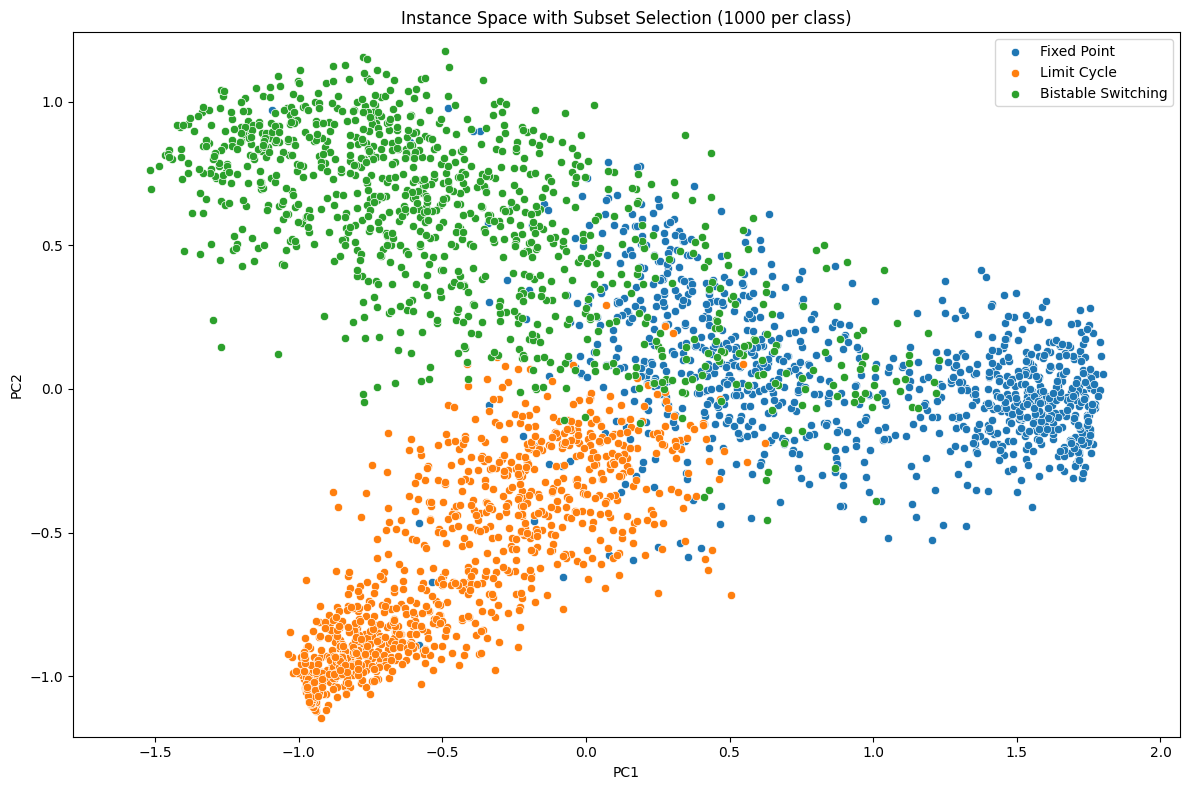

In [1545]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca_subset[:1000,0], y=pca_subset[:1000,1], label='Fixed Point')
sns.scatterplot(x=pca_subset[1000:2000,0], y=pca_subset[1000:2000,1], label='Limit Cycle')
sns.scatterplot(x=pca_subset[2000:,0], y=pca_subset[2000:,1], label='Bistable Switching')
plt.title('Instance Space with Subset Selection (1000 per class)')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Epsilon curves implementation

In [1505]:
# propose epsilon value
# generate N samples from all 3 classes
# Project into calibrated space and use proposed epsilon value to do inference
# compare prediction against ground truth label
# compute accuracy

In [1791]:
epsilons = np.linspace(0.2, 2, 100) # scan across proposed epsilon values
# generate validation data
ts_validate_lc, df_validate_lc = gen_limitCycle(500)
ts_validate_fp, df_validate_fp = gen_fixedpoint(166)
ts_validate_sw, df_validate_sw = gen_switching(500)

Generating Limit Cycle Instances...
0/500
100/500
200/500
300/500
400/500
Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...


In [1792]:
validation_data_labels = np.concatenate([np.tile(0, 500), np.tile(1, 498), np.tile(2, 500)]) # 0 = FP, 1 = LC, 2 = BS

In [1793]:
validation_data = pd.concat([df_validate_fp, df_validate_lc, df_validate_sw])
val_data_embeddings = pca.transform(mm.transform(sigmoid_transformer.transform(rs.transform(validation_data.iloc[:,:22]))))

In [1794]:
# store num correct for each epsilon
accuracies = list()
for epsilon in epsilons:
    # cycle through N validation samples
    predictions = list()
    for index, pos in enumerate(val_data_embeddings): 
        # pca_subset
        x, y = pos
        neighbours = np.argwhere(((pca_subset[:,0] - x)**2 + (pca_subset[:,1] - y)**2) < epsilon**2)
        neighbours = labels_encoding[neighbours] # get labels of neighbouring points
        unique, counts = np.unique(neighbours, return_counts=True)
        pred = unique[np.argmax(counts)]
        predictions.append(pred)
    matches = np.count_nonzero(predictions == validation_data_labels)
    accuracy = matches/len(val_data_embeddings)
    accuracies.append(accuracy)


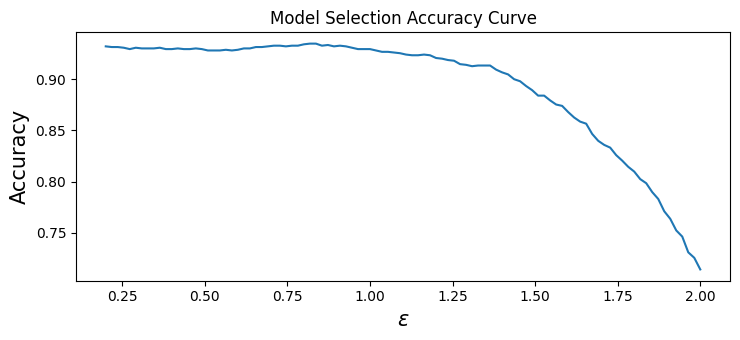

In [1795]:
plt.plot(epsilons, accuracies)
plt.title('Model Selection Accuracy Curve')
plt.xlabel(r'$\epsilon$', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()